## Import libraries

In [2]:
# Import the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import spacy
from langdetect import detect
from deep_translator import GoogleTranslator
import tqdm

In [3]:
# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

# set the deterministic flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load Reviews Dataset

In [4]:
# Load the data
reviews = pd.read_json("jumiascraper/new_reviews.json")
reviews.head()

,product,header,review,date_reviewed
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,my face tone has improved after 3 weeks of usage,I would recommend this product to anyone that ...,21-07-2024
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,Amazing,Works as described\n,19-07-2024
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,Good,Work for me,15-07-2024
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,its nice though a little.bit.itchy,Increase the quantity,12-07-2024
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,awesome,It understands the assignment ☺️,12-07-2024


In [5]:
# Drop the null values

reviews.dropna(inplace=True)

In [6]:
# Combine the header and review columns
reviews["full_review"] = reviews["header"] + "." + reviews["review"]

reviews["full_review"][0] # view the 1st full review

"my face tone has improved after 3 weeks of usage .I would recommend this product to anyone that has an uneven face. The dark shaded areas and dark spots on the face slowly disappear after 3 weeks of usage. You have to be patient for even 4 months to see progress. So it's all about patience"

In [7]:
# drop the header & reviwe columns

reviews.drop(columns=["header", "review"], inplace=True)

In [8]:
# Size of the data

print(f"The dataset has {reviews.shape[0]} rows and {reviews.shape[1]} columns")

The dataset has 6009 rows and 3 columns


In [9]:
# Check duplicates

reviews[reviews.duplicated(keep=False, subset=["product", "date_reviewed", "full_review"])]

,product,date_reviewed,full_review
153,Garnier Color Naturals Fr/gb/ar 5,05-07-2021,hair colour by garnier.I am waiting for a cred...
154,Garnier Color Naturals Fr/gb/ar 5,05-07-2021,hair colour by garnier.I am waiting for a cred...
230,Garnier Even & Matte Vitamin C Booster Serum ...,03-07-2024,vitamin c serum.Love it so much I'm on my thir...
231,Garnier Even & Matte Vitamin C Booster Serum ...,03-07-2024,vitamin c serum.Love it so much I'm on my thir...
370,Garnier Skin Active Hydrabomb Pomegranate Tiss...,16-11-2022,great customer service.Delivered in good time ...
...,...,...,...
5871,Garnier Pure Active 3 In1 Charcoal Anti Blac...,02-07-2021,Authenticity.Everything
5896,Garnier Pure Active 3 In1 Charcoal Anti Blac...,30-05-2021,perfection in a bottle.I noticed a change on m...
5897,Garnier Pure Active 3 In1 Charcoal Anti Blac...,30-05-2021,perfection in a bottle.I noticed a change on m...
5940,Garnier Pure Active 3 In1 Charcoal Anti Blac...,28-06-2020,good.I will rate it at 50/50


In [10]:
#drop duplicates

reviews.drop_duplicates(subset=["product", "date_reviewed", "full_review"], keep="first", inplace=True)
reviews.shape[0]

5890

In [11]:
# Cheeck for unique producst
reviews["product"].nunique()

45

## Load Products Dataset

In [12]:
# Load the products data

products = pd.read_json("jumiascraper/new_product.json")
products.head()

,product,price,store,brand,avg_rating,number_ratings,number_reviews
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,"KSh 1,034",Official Store,Garnier,4.4 out of 5,(5334 verified ratings),Product Reviews (875)
1,Garnier Skin Active Hydrabomb Pomegranate Tiss...,KSh 365,Official Store,Garnier,4.6 out of 5,(1546 verified ratings),Product Reviews (191)
2,Garnier Skin Active Hydrabomb Chamomile Tissue...,KSh 365,Official Store,Garnier,4.6 out of 5,(1056 verified ratings),Product Reviews (137)
3,Garnier Micellar Cleansing Water For Sensitive...,KSh 744,Official Store,Garnier,4.5 out of 5,(2018 verified ratings),Product Reviews (356)
4,Garnier Mineral Men Invisible Roll-on - 50ml,KSh 350,Official Store,Garnier,4.5 out of 5,(65 verified ratings),Product Reviews (13)


In [13]:
# Fill the missing values with Official Store

products["store"] = products["store"].fillna("Official Store")

In [14]:
# Products

products.iloc[np.where(products["number_reviews"].isna())]

,product,price,store,brand,avg_rating,number_ratings,number_reviews
17,Garnier Ultra Doux Black Charcoal & Nigella Se...,KSh 695,Official Store,Garnier,0 out of 5,(No ratings available),NaN
22,Garnier Ultra Doux Honey Treasures Shampoo 400ml,KSh 795,Official Store,Garnier,0 out of 5,(No ratings available),NaN
23,Garnier Ultra Doux Olive Mythic Shampoo 400ml,KSh 795,Official Store,Garnier,0 out of 5,(No ratings available),NaN
24,Garnier Ultra Doux Mythic Olive Conditioner,KSh 695,Official Store,Garnier,0 out of 5,(No ratings available),NaN
26,Garnier Ultra Doux Almond Milk Hydrating Condi...,KSh 695,Official Store,Garnier,0 out of 5,(No ratings available),NaN
27,Garnier Ultra Doux Avocado & Shea Butter Nouri...,KSh 695,Official Store,Garnier,0 out of 5,(No ratings available),NaN
28,Garnier Ultra Doux Avocado Oil & Shea Butter S...,KSh 795,Official Store,Garnier,0 out of 5,(No ratings available),NaN
33,"Garnier Pure Active Cleanser 3IN1 Clay Wash, ...",KSh 720,Official Store,Garnier,0 out of 5,(No ratings available),NaN


In [15]:
# Drop the missing values (number_reviews)

products.dropna(inplace=True)

In [16]:
# Size of data

print(f"The dataset has {products.shape[0]} rows & {products.shape[1]} columns")

The dataset has 46 rows & 7 columns


In [17]:
# Remove the currency name & commas in the price column
pattern = r'\,+'

products["price"] = products["price"].apply(lambda x: x.split()[1]).apply(lambda x: re.sub(pattern, "", x)).astype("int64")

In [18]:
# Get the rating No. only

products["avg_rating"] = products["avg_rating"].apply(lambda x: x.split()[0]).astype("float32")

In [19]:
# Get the value of the number_ratings

pattern = r'\d+' # define the pattern

products["number_ratings"] = products["number_ratings"].apply(lambda x: " ".join(re.findall(pattern, x)))#.astype("int64")
products["number_ratings"] = products["number_ratings"].astype("int64")

In [20]:
# Cover the column to a string & get the value

pattern = r'\d+' # define the pattern

products["number_reviews"] = products["number_reviews"].apply(lambda x: " ".join(re.findall(pattern, x)))#.astype("int64")
products["number_reviews"] = products["number_reviews"].astype("int64")

In [21]:
# Summary of the data
products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 0 to 53
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product         46 non-null     object 
 1   price           46 non-null     int64  
 2   store           46 non-null     object 
 3   brand           46 non-null     object 
 4   avg_rating      46 non-null     float32
 5   number_ratings  46 non-null     int64  
 6   number_reviews  46 non-null     int64  
dtypes: float32(1), int64(3), object(3)
memory usage: 2.7+ KB


In [22]:
#products.to_csv("raws_products.csv")

In [23]:
# # Save the data
# products.to_csv("garnier_products.csv")

In [24]:
products["product"].nunique()

45

In [25]:
# Sort according to value

top_by_reviews = products.sort_values(by="number_reviews", ascending=False).head(5)
top_by_reviews

,product,price,store,brand,avg_rating,number_ratings,number_reviews
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875
11,Garnier Even & Matte Vitamin C Booster Serum ...,1050,Official Store,Garnier,4.3,4553,760
39,Garnier Even & Matte Dark Spot Corrector,542,Official Store,Garnier,4.0,2997,583
49,Garnier Even & Matte Vitamin C Cleansing Foam,579,Official Store,Garnier,4.4,2435,430
3,Garnier Micellar Cleansing Water For Sensitive...,744,Official Store,Garnier,4.5,2018,356


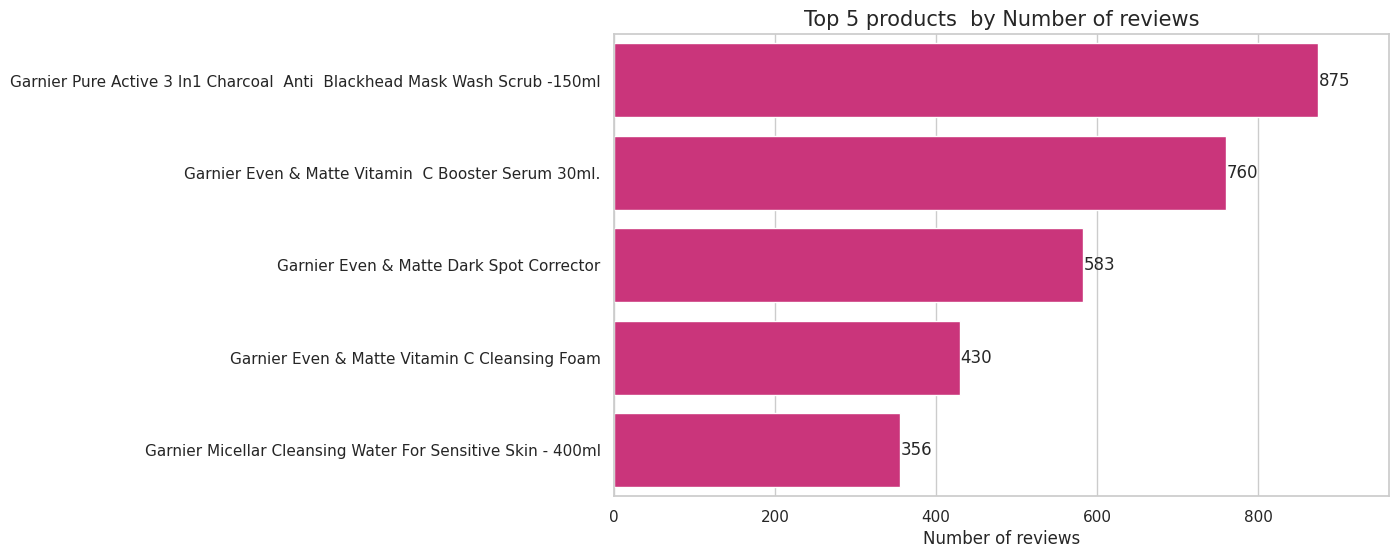

In [84]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

loreal_palette = ['#E31C79', '#000000', '#FFD700', '#FFFFFF']  # Pink, Black, Gold, White
sns.set_palette(loreal_palette)
ax = sns.barplot(data=top_by_reviews, x="number_reviews", y="product")


# Annotate each bar with the percentage value
# Annotate each bar with the percentage value at the end
for i, v in enumerate(top_by_reviews['number_reviews']):
    ax.text(v + 0.5, i, f"{v}", va='center')

# Adjust the x-axis limit to make room for the annotations
plt.xlim(0, max(top_by_reviews['number_reviews']) * 1.1)

# Remove the x-axis label as it's now redundant
plt.xlabel('Number of reviews')
plt.ylabel('')
plt.title("Top 5 products  by Number of reviews", fontsize=15)

plt.savefig('top_5_products_by_number-of-reviews.png', dpi=300, bbox_inches='tight')

plt.show()

## Merge Reviews & Dataset

In [27]:
# Merge the separate the dataframes  into one 
df = pd.merge(products, reviews, on="product", how="inner")
df.shape[0]

5997

In [28]:
# # save the combined dataframe
# df.to_csv("full_garnier.csv")

In [29]:
# Identify the number of unique products

df["product"].nunique()

45

In [30]:
df.head()

,product,price,store,brand,avg_rating,number_ratings,number_reviews,date_reviewed,full_review
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,21-07-2024,my face tone has improved after 3 weeks of usa...
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,19-07-2024,Amazing.Works as described\n
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,15-07-2024,Good .Work for me
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,its nice though a little.bit.itchy.Increase th...
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,awesome.It understands the assignment ☺️


In [31]:
# Summary data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5997 entries, 0 to 5996
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product         5997 non-null   object 
 1   price           5997 non-null   int64  
 2   store           5997 non-null   object 
 3   brand           5997 non-null   object 
 4   avg_rating      5997 non-null   float32
 5   number_ratings  5997 non-null   int64  
 6   number_reviews  5997 non-null   int64  
 7   date_reviewed   5997 non-null   object 
 8   full_review     5997 non-null   object 
dtypes: float32(1), int64(3), object(5)
memory usage: 398.4+ KB


In [32]:
# Convert all texts to english
def translate_text(text):
    translated = GoogleTranslator(source="auto", target="en").translate(str(text))
    return translated
                                            
#Apply the translation function with a progress bar
df['review'] = df['full_review'].apply(translate_text)

df.head()

,product,price,store,brand,avg_rating,number_ratings,number_reviews,date_reviewed,full_review,review
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,21-07-2024,my face tone has improved after 3 weeks of usa...,my face tone has improved after 3 weeks of usa...
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,19-07-2024,Amazing.Works as described\n,Amazing.Works as described
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,15-07-2024,Good .Work for me,Good .Work for me
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,its nice though a little.bit.itchy.Increase th...,its nice though a little.bit.itchy.Increase th...
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,awesome.It understands the assignment ☺️,awesome.It understands the assignment ☺️


In [33]:
# Identify the missing values
df.iloc[np.where(df["review"].isna())[0]]["full_review"]

1720       ..............
1796              .. ... 
5038    ????????.????????
Name: full_review, dtype: object

In [34]:
# Drop the missing values
df.dropna(inplace=True)

df.shape[0] # How many rows left

5994

In [35]:
# Replace the "\n"
df["new_review"] = df["review"].apply(lambda text: text.replace("\n", " "))

In [36]:
df.head()

,product,price,store,brand,avg_rating,number_ratings,number_reviews,date_reviewed,full_review,review,new_review
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,21-07-2024,my face tone has improved after 3 weeks of usa...,my face tone has improved after 3 weeks of usa...,my face tone has improved after 3 weeks of usa...
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,19-07-2024,Amazing.Works as described\n,Amazing.Works as described,Amazing.Works as described
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,15-07-2024,Good .Work for me,Good .Work for me,Good .Work for me
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,its nice though a little.bit.itchy.Increase th...,its nice though a little.bit.itchy.Increase th...,its nice though a little.bit.itchy.Increase th...
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Official Store,Garnier,4.4,5334,875,12-07-2024,awesome.It understands the assignment ☺️,awesome.It understands the assignment ☺️,awesome.It understands the assignment ☺️


In [37]:
# More Feature engineering

df.drop(columns=["store", "number_reviews", "number_ratings", "full_review", "review"], inplace=True) # drop named columns

df.rename({"avg_rating": "average_rating", "date_reviewed": "date", "new_review": "review"}, inplace=True, axis=1) # rename the highlighted columns

df.head() # View the data to confirm changes

,product,price,brand,average_rating,date,review
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,21-07-2024,my face tone has improved after 3 weeks of usa...
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,19-07-2024,Amazing.Works as described
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,15-07-2024,Good .Work for me
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,its nice though a little.bit.itchy.Increase th...
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,awesome.It understands the assignment ☺️


In [38]:
# Determine the device

device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device

0

## Sentiment Analysis

In [51]:
# Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load the model from hugging face
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model & tokenizer into the pipeline
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    top_k = 1
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# Confirm effectiveness of the model

test_review = df["review"][0]
sentiment = nlp(test_review)[0][0]["label"]
sentiment

'positive'

In [53]:
nlp(test_review)[0]

[{'label': 'positive', 'score': 0.9084733128547668}]

In [54]:
# create a column for sentiments
df["sentiment"] = df["review"].apply(lambda x: nlp(x)[0][0]["label"])

In [55]:
# get the percentage of negativereviews for all products

sentiment_counts = df.groupby(['product', 'sentiment']).size().unstack(fill_value=0) # group products ny sentiments

sentiment_counts['negative_percentage'] = round((sentiment_counts['negative'] / sentiment_counts.sum(axis=1)) * 100, 1)# get percentage of negative reviews

sentiment_counts['postive_percentage'] = round((sentiment_counts['positive'] / sentiment_counts.sum(axis=1)) * 100, 1)

sentiment_counts['number_reviews'] = sentiment_counts[["negative", "neutral", "positive"]].sum(axis=1)

#sentiment_counts.sort_values(by="positive_percentage", ascending=False) # sort by positive reviews

sentiment_counts.sort_values(by="postive_percentage", ascending=False)

sentiment,negative,neutral,positive,negative_percentage,postive_percentage,number_reviews
product,,,,,,
Garnier Color Naturals Fr/gb/ar 3 Ch Fon (Dark Brown) – 110ml,0,0,3,0.0,100.0,3
Garnier Pure Active Daily Pore Reducing Toner,0,0,3,0.0,100.0,3
"Garnier Pure Active Cleanser 3IN1 Clay Wash, Scrub, Mask 150ml",0,0,1,0.0,100.0,1
Garnier Boost It Up Bundle,0,0,4,0.0,100.0,4
Garnier Even & Matte Cleansing Foam 100ml,0,0,4,0.0,100.0,4
Garnier Skin Active Hydrabomb Green Tea Tissue Face Mask,10,6,198,4.7,90.5,214
Garnier AHA+BHA Charcoal Serum + Pure Active 3-in-1 Charcoal Mask (Anti Acne Skin Care Kit),5,5,115,4.0,89.1,125
Garnier Micellar Oil-Infused Cleansing Water (Oil In Water) - 400ml,7,4,120,5.3,88.0,131
Garnier Pure Active 3 In1 Charcoal Anti Blackhead Mask Wash Scrub -150ml,56,43,757,6.5,87.8,856


In [56]:
sentiment_totals = sentiment_counts[['negative', 'neutral', 'positive']].sum()
sentiment_totals

sentiment
negative     648
neutral      439
positive    4907
dtype: int64

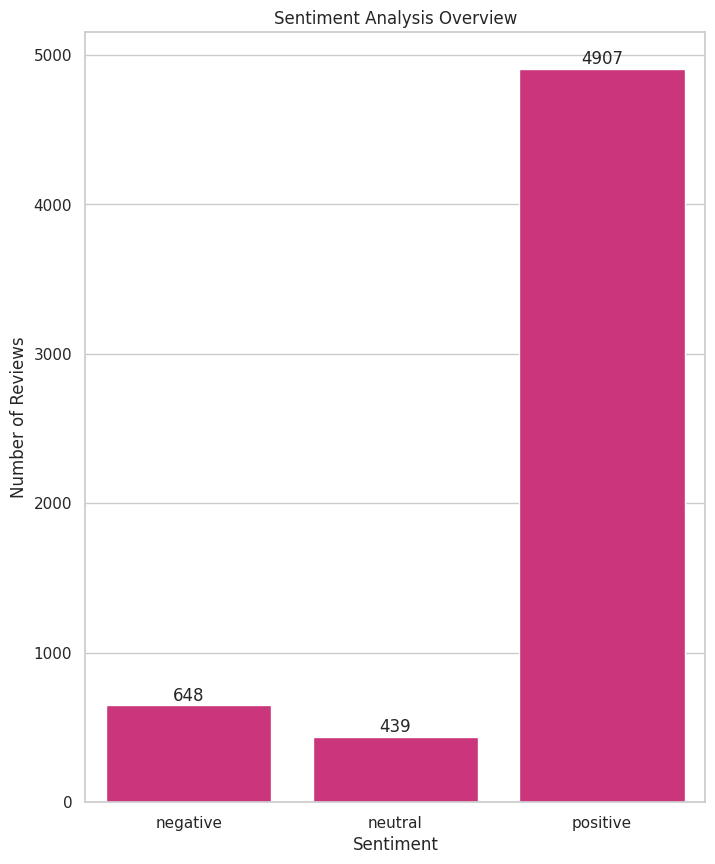

In [60]:
# Plot of the total sum of each sentiment
sns.set(style="whitegrid")
plt.figure(figsize=(8, 10))

loreal_palette = ['#E31C79']  # Pink, Black, Gold, White
sns.set_palette(loreal_palette)
ax = sns.barplot(x=sentiment_totals.index, y=sentiment_totals.values)

# Annotate each bar with the total value
for i, v in enumerate(sentiment_totals.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')

# Add titles and labels
plt.title('Sentiment Analysis Overview')
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment')

#plt.savefig("sentiment-analysis-overview.png", dpi=300, bbox_inches='tight')

plt.show()

In [61]:
# Merge Negative_Percentage back to the original DataFrame
df = df.merge(sentiment_counts[['negative_percentage', "postive_percentage", "number_reviews"]], on='product', how='left')

In [62]:
# Get the top 5 products by number of reviews
new_df = df.drop_duplicates(subset=["product"]).sort_values(by="number_reviews", ascending=False).reset_index(drop=True).head()
new_df

,product,price,brand,average_rating,date,review,sentiment,negative_percentage,postive_percentage,number_reviews
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,21-07-2024,my face tone has improved after 3 weeks of usa...,positive,6.5,87.8,856
1,Garnier Even & Matte Vitamin C Booster Serum ...,1050,Garnier,4.3,25-07-2024,soft and glowy.Its the glow for me,positive,10.2,82.0,736
2,Garnier Even & Matte Dark Spot Corrector,542,Garnier,4.0,19-07-2024,Jayden.It's working ????,neutral,25.6,57.7,562
3,Garnier Even & Matte Vitamin C Cleansing Foam,579,Garnier,4.4,25-07-2024,soap.Great product,positive,7.5,83.6,415
4,Garnier Micellar Cleansing Water For Sensitive...,744,Garnier,4.5,26-07-2024,I like it.Good for my sensitive skin,positive,9.1,82.7,350


In [63]:
#top_products = df.drop_duplicates(subset="product").sort_values(by="number_reviews", ascending=False).head(10)
top_products_negative_reviews = new_df.sort_values(by="negative_percentage", ascending=False)
top_products_negative_reviews

,product,price,brand,average_rating,date,review,sentiment,negative_percentage,postive_percentage,number_reviews
2,Garnier Even & Matte Dark Spot Corrector,542,Garnier,4.0,19-07-2024,Jayden.It's working ????,neutral,25.6,57.7,562
1,Garnier Even & Matte Vitamin C Booster Serum ...,1050,Garnier,4.3,25-07-2024,soft and glowy.Its the glow for me,positive,10.2,82.0,736
4,Garnier Micellar Cleansing Water For Sensitive...,744,Garnier,4.5,26-07-2024,I like it.Good for my sensitive skin,positive,9.1,82.7,350
3,Garnier Even & Matte Vitamin C Cleansing Foam,579,Garnier,4.4,25-07-2024,soap.Great product,positive,7.5,83.6,415
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,21-07-2024,my face tone has improved after 3 weeks of usa...,positive,6.5,87.8,856


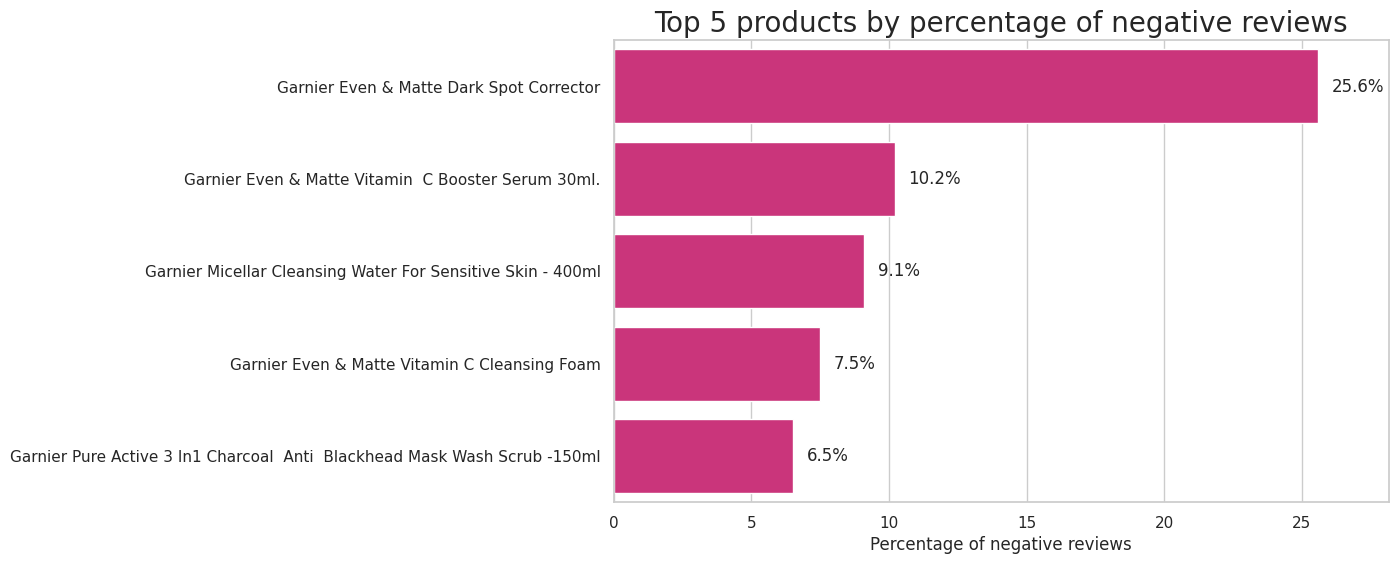

In [64]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

loreal_palette = ['#E31C79']  # Pink, Black, Gold, White
sns.set_palette(loreal_palette)
ax = sns.barplot(data=top_products_negative_reviews, y="product", x="negative_percentage")


# Annotate each bar with the percentage value
# Annotate each bar with the percentage value at the end
for i, v in enumerate(top_products_negative_reviews['negative_percentage']):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

# Adjust the x-axis limit to make room for the annotations
plt.xlim(0, max(top_products_negative_reviews['negative_percentage']) * 1.1)

# Remove the x-axis label as it's now redundant
plt.xlabel('Percentage of negative reviews')
plt.ylabel('')
plt.title("Top 5 products by percentage of negative reviews", fontsize=20)

plt.savefig("Top-5-products-percentage-negative-reviews.png", dpi=300, bbox_inches='tight')


plt.show()

## Embedding

In [65]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

# Determine the model
model = "sentence-transformers/all-MiniLM-L6-v2"

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model, do_lower_case=True)

# Determine the embedding Model
retriever = SentenceTransformer(model, tokenizer, device=device)

In [66]:
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Vector Database

In [67]:
# Import PineCone Vectordb library
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec
from config import pinecone_key

# Load the api-key
pc = Pinecone(api_key=pinecone_key)

In [68]:
retriever.get_sentence_embedding_dimension()

384

In [70]:
# Define the Index name

index_name = "loreal-sentiments-ke"

# Check if index exists
if index_name not in pc.list_indexes().names():
  # Create index if it does not exist
  pc.create_index(
      index_name,
      dimension=retriever.get_sentence_embedding_dimension(),
      metric="cosine",
      spec=ServerlessSpec(
          cloud="aws",
          region="us-east-1")
      )

# connect to the index created
index = pc.Index(index_name)

In [71]:
def get_sentiment(reviews):

  labels = []

  scores = []

  for review in reviews:

    sentiment = nlp(review)[0][0]

    labels.append(sentiment["label"])

    scores.append(sentiment["score"])

  return labels, scores

In [72]:
# Create timestamps
from dateutil.parser import parse

def get_timestamp(dates):

  timestamps = [parse(d).timestamp() for d in dates]

  return timestamps

In [73]:
clean_df = df.copy()
clean_df.head()

,product,price,brand,average_rating,date,review,sentiment,negative_percentage,postive_percentage,number_reviews
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,21-07-2024,my face tone has improved after 3 weeks of usa...,positive,6.5,87.8,856
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,19-07-2024,Amazing.Works as described,positive,6.5,87.8,856
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,15-07-2024,Good .Work for me,positive,6.5,87.8,856
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,its nice though a little.bit.itchy.Increase th...,positive,6.5,87.8,856
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,awesome.It understands the assignment ☺️,positive,6.5,87.8,856


In [74]:
clean_df.drop(columns=["negative_percentage", "postive_percentage", "sentiment"], inplace=True)
clean_df.head()

,product,price,brand,average_rating,date,review,number_reviews
0,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,21-07-2024,my face tone has improved after 3 weeks of usa...,856
1,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,19-07-2024,Amazing.Works as described,856
2,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,15-07-2024,Good .Work for me,856
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,its nice though a little.bit.itchy.Increase th...,856
4,Garnier Pure Active 3 In1 Charcoal Anti Blac...,1034,Garnier,4.4,12-07-2024,awesome.It understands the assignment ☺️,856


In [75]:
from tqdm.auto import tqdm


# determine the batch size
batch_size = 64

# Create the for loop
for i in tqdm(range(0, len(clean_df), batch_size)):

  #find end of batch
  i_end = min(i+batch_size, len(clean_df))

  # extract batch
  batch = clean_df.iloc[i:i_end].copy()

  #generate embeddings for search
  emb = retriever.encode(batch["review"].to_list())

  # convert date to timesatamps to enable filtering
  timestamp = get_timestamp(batch["date"].to_list())
  batch["timestamp"] = timestamp

  # get sentiment label & score for each batch
  label, score = get_sentiment(batch["review"])
  batch["sentiment_label"] = label
  batch["sentiment_score"] = score

  # Additional details like price in metadata
  meta = batch.to_dict(orient="records")

  # Create unique ids
  ids = [f"{idx}" for idx in range(i, i_end)]

  # add all to upsert list
  to_upsert = list(zip(ids, emb, meta))

  # insert the records to pinecone
  _ = index.upsert(vectors=to_upsert)

  0%|          | 0/94 [00:00<?, ?it/s]

In [76]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 5994}},
 'total_vector_count': 5994}

In [77]:
query = "What's the overall sentiments of all our products"

# Create Dense embedding on the query
xq = retriever.encode(query).tolist()

# Query the database
results = index.query(vector=xq, top_k=6116, include_metadata=True)

In [78]:
results["matches"][:5]

[{'id': '1912',
  'metadata': {'average_rating': 4.300000190734863,
               'brand': 'Garnier',
               'date': '22-12-2023',
               'number_reviews': 125.0,
               'price': 2167.0,
               'product': 'Garnier AHA+BHA Charcoal Serum + Pure Active 3-in-1 '
                          'Charcoal Mask (Anti Acne Skin Care Kit)',
               'review': 'quality.Product as expected',
               'sentiment_label': 'positive',
               'sentiment_score': 0.6160459518432617,
               'timestamp': 1703192400.0},
  'score': 0.5079953,
  'sparse_values': {'indices': [], 'values': []},
  'values': []},
 {'id': '4040',
  'metadata': {'average_rating': 4.0,
               'brand': 'Garnier',
               'date': '24-06-2022',
               'number_reviews': 562.0,
               'price': 542.0,
               'product': 'Garnier Even & Matte Dark Spot Corrector',
               'review': 'good product.Increase the quantity of the products',
    

In [79]:
# Define function to get sentiment by year
def count_sentiment_by_year(results):
    sentiments = {}

    pattern = r'\d{4}'

    # Iterate through the search results
    for r in results["matches"]:
        year_match = re.findall(pattern, r["metadata"]["date"])
        if year_match:
            year = year_match[0]
            
            
            sentiment = r["metadata"]["sentiment_label"]

            # Initialize year dict if not present
            if year not in sentiments:
                sentiments[year] = {
                    "negative": 0,
                    "neutral": 0,
                    "positive": 0
                }
    
            # Increment sentiment count for the year
            sentiments[year][sentiment] += 1

    return sentiments

In [80]:
sentiment_by_year = count_sentiment_by_year(results)

# Convert dictionary to DataFrame
year_df = pd.DataFrame(sentiment_by_year).T.reset_index()
year_df = year_df.rename(columns={'index': 'Year'})

# Convert 'Year' column to a datetime object
year_df['Year'] = pd.to_datetime(year_df['Year'], format='%Y')

# Melt the DataFrame to have one column for sentiment and another for counts
year_df_melted = year_df.melt(id_vars='Year', var_name='Sentiment', value_name='Count')
#year_df_melted

year_df_melted.drop(np.where(year_df_melted["Year"] == "2024-01-01")[0], axis=0, inplace=True)

In [83]:
year_df

,Year,negative,neutral,positive
0,2023-01-01,169,104,1270
1,2022-01-01,180,121,1234
2,2021-01-01,145,121,1116
3,2024-01-01,73,52,624
4,2020-01-01,61,33,452
5,2019-01-01,19,5,177
6,2018-01-01,1,3,34


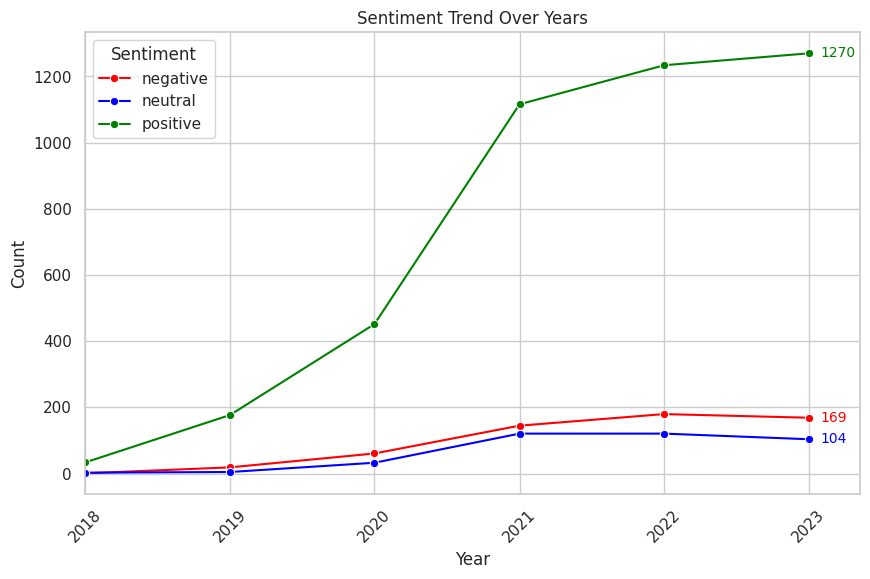

In [81]:
# Plot the data using Seaborn
plt.figure(figsize=(10, 6))

# Define a custom color palette
custom_palette = {'negative': 'red', 'neutral': 'blue', 'positive': 'green'}

sns.lineplot(data=year_df_melted, x='Year', y='Count', hue='Sentiment', marker='o', palette=custom_palette)


# Add titles and labels
plt.title('Sentiment Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Extend the x-axis limit to create space for annotations
plt.xlim(year_df_melted['Year'].min(), year_df_melted['Year'].max() + pd.Timedelta(days=130))

# Annotate the end of each line with the count value
for sentiment in year_df_melted['Sentiment'].unique():
    sentiment_data = year_df_melted[year_df_melted['Sentiment'] == sentiment]
    last_year = sentiment_data['Year'].max()
    last_value = sentiment_data[sentiment_data['Year'] == last_year]['Count'].values[0]
    plt.text(last_year + pd.Timedelta(days=30), last_value, f'{last_value}', 
             color=custom_palette[sentiment],
             ha='left', va='center', fontsize=10)


# save image
plt.savefig("sentiment-trend-over-years.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [94]:
#query = "what are the best features"

# Create Dense embedding on the query
#xq = retriever.encode(query).tolist()

# Query the database
#results = index.query(vector=xq, include_metadata=True, top_k=1000, filter={"$and": [{"sentiment_label": {"$eq": "positive"}}, {"sentiment_score": {"$gte": 0.80}}]})

In [96]:
# Define the function to get the positive reviews
#def get_reviews(result):

#  reviews = []

#  for r in result["matches"]:

#   reviews.append(r["metadata"]["review"])


#return " ".join(reviews)

In [97]:
# Call the function to get the reviews
#from collections import Counter

#positive_reviews = get_reviews(results).lower()

#nlp = spacy.load("en_core_web_lg")

#tokens = [token.text for token in nlp(positive_reviews) if token.pos_ in ["NOUN", "ADJ", "VERB", "ADV"] and not token.is_stop] 

# Count word frequencies
#word_freq = Counter(tokens)

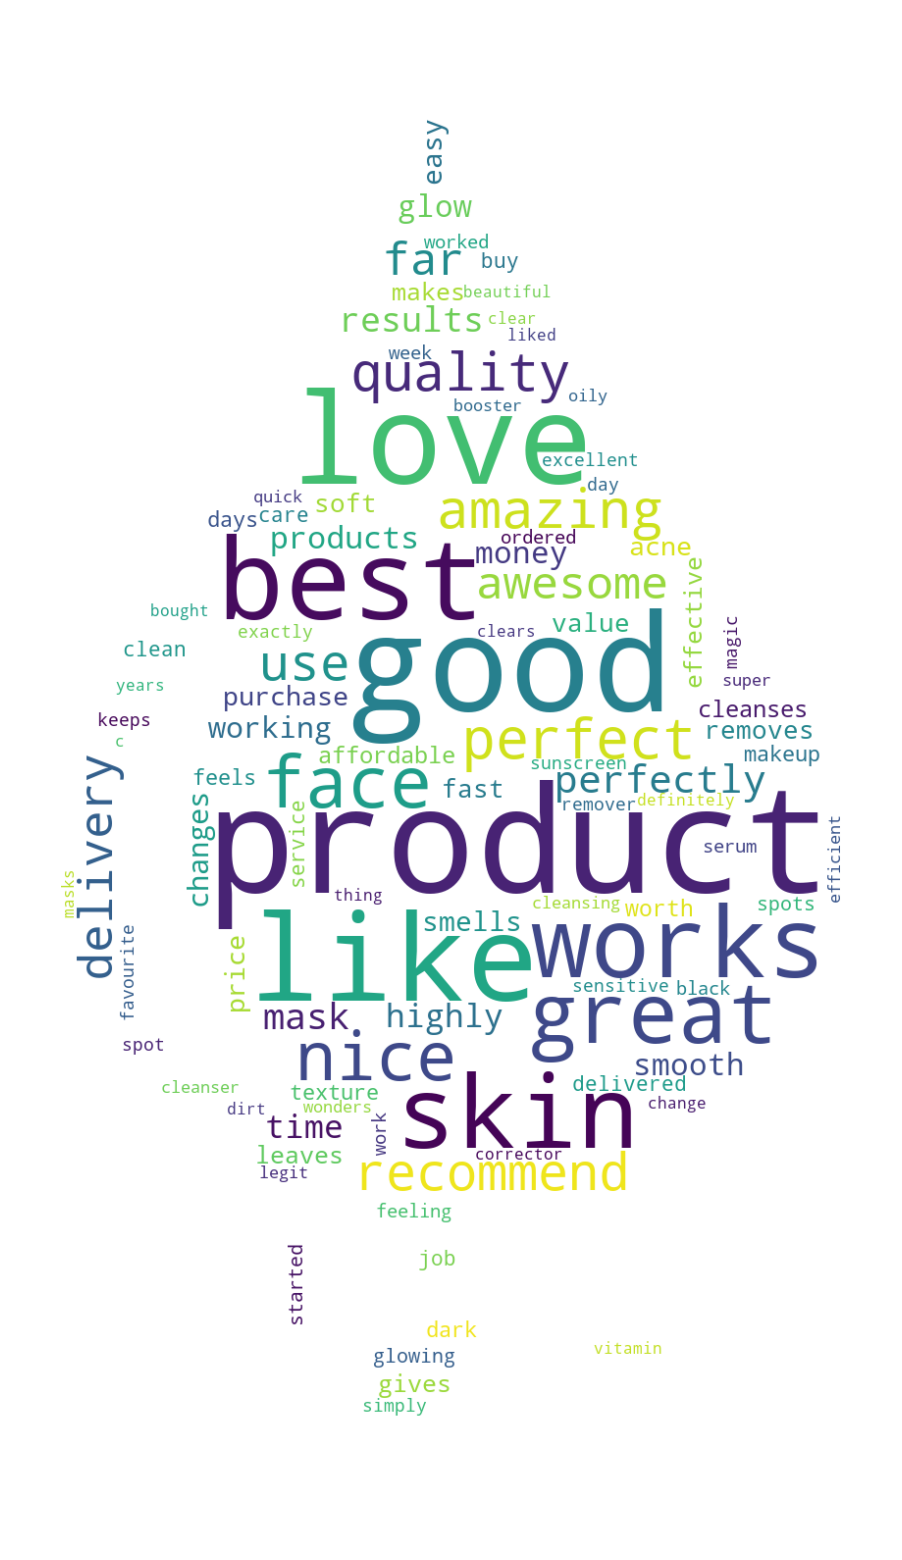

In [100]:
#Display the word cloud
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from PIL import Image
#import numpy as np

# Load mask image
#mask = np.array(Image.open("droplet logo.jpg"))

#Initialize word cloud
#wc = WordCloud(background_color="white", random_state=1, max_words=100, normalize_plurals=True, mask=mask).generate_from_frequencies(word_freq)

#Plot
#plt.figure(figsize=(20,20))
#plt.imshow(wc, interpolation="bilinear")
#plt.axis("off")
#plt.tight_layout(pad=1)

#plt.savefig('garnier_positive.png', dpi=300, bbox_inches='tight')

#plt.show()

In [425]:
#query = "what are the criticisms of the product"

#xq = retriever.encode(query).tolist()

#results = index.query(vector=xq, include_metadata=True, top_k=600, filter={"sentiment_label": "negative"})

In [427]:
#def product_count(results):

#    product_count = {}

#    for r in results["matches"]:
        
        # Extract product name
 #       product = r["metadata"]["product"]
        
            # Count occurrence of each product
  #      if product in product_count:
   #         product_count[product] += 1
    #    else:
            product_count[product] = 1

    # Sort the dictionary items by count in descending order
    #sorted_product_count = sorted(product_count.items(), key=lambda x: x[1], reverse=True)
                
    #return sorted_product_count

In [428]:
# Get the 5 products with the most dislikes
#negative_product_count = product_count(results)
#top_five_negative = negative_product_count[:5]

In [429]:
#top_negative_reviews_by_product = pd.DataFrame(top_five_negative, columns=["product", "count"])
#top_negative_reviews_by_product.to_csv("top_negative_reviews_by_product.csv")
#top_negative_reviews_by_product.head()

,product,count
0,Garnier Even & Matte Dark Spot Corrector,130
1,Garnier Even & Matte Oily Skin Face Moisturizer,71
2,Garnier Even & Matte Vitamin C Booster Serum ...,71
3,Garnier Pure Active 3 In1 Charcoal Anti Blac...,53
4,Garnier Anti-Blemish Charcoal Serum With AHA+B...,34


In [204]:
# Save the data
#new_df.to_csv("top_five_products_by_negative_reviews.csv")

In [103]:
# Creaye the query
#query = "What are biggest customer dislikes"

# Embed the query
#xq = retriever.encode(query).tolist()

# Query the database
#results = index.query(vector=xq, include_metadata=True, top_k=130, filter={"$and": [{"sentiment_label": "negative"}, {"product": {"$eq":"Garnier Even & Matte Dark Spot Corrector"}}]})

In [104]:
#negative_spot_reviews = get_reviews(results).lower()
#negative_reviews = negative_reviews

In [121]:
#spot_tokens = [token.lemma_ for token in nlp(negative_spot_reviews) if token.pos_ in ["ADV", "ADJ", "NOUN", "VERB"]]
#word_freq = Counter(spot_tokens)

In [122]:
#word_freq

Counter({'product': 52,
         'work': 32,
         'use': 25,
         'tube': 25,
         'empty': 21,
         'little': 19,
         'too': 15,
         'like': 15,
         'spot': 15,
         'air': 14,
         'week': 14,
         'have': 12,
         'change': 12,
         'good': 11,
         'face': 11,
         'small': 11,
         'quantity': 11,
         'more': 11,
         'bad': 10,
         'very': 10,
         'dark': 10,
         'even': 10,
         'still': 9,
         'do': 9,
         'skin': 9,
         'full': 9,
         'almost': 9,
         'fill': 9,
         'so': 8,
         'make': 8,
         'half': 8,
         'hate': 7,
         'inside': 7,
         'content': 7,
         'month': 7,
         'disappointed': 7,
         'well': 7,
         'glitter': 7,
         'see': 7,
         'result': 7,
         'only': 6,
         'amount': 6,
         'give': 6,
         'less': 6,
         'now': 6,
         'never': 5,
         'expensive': 5,
     

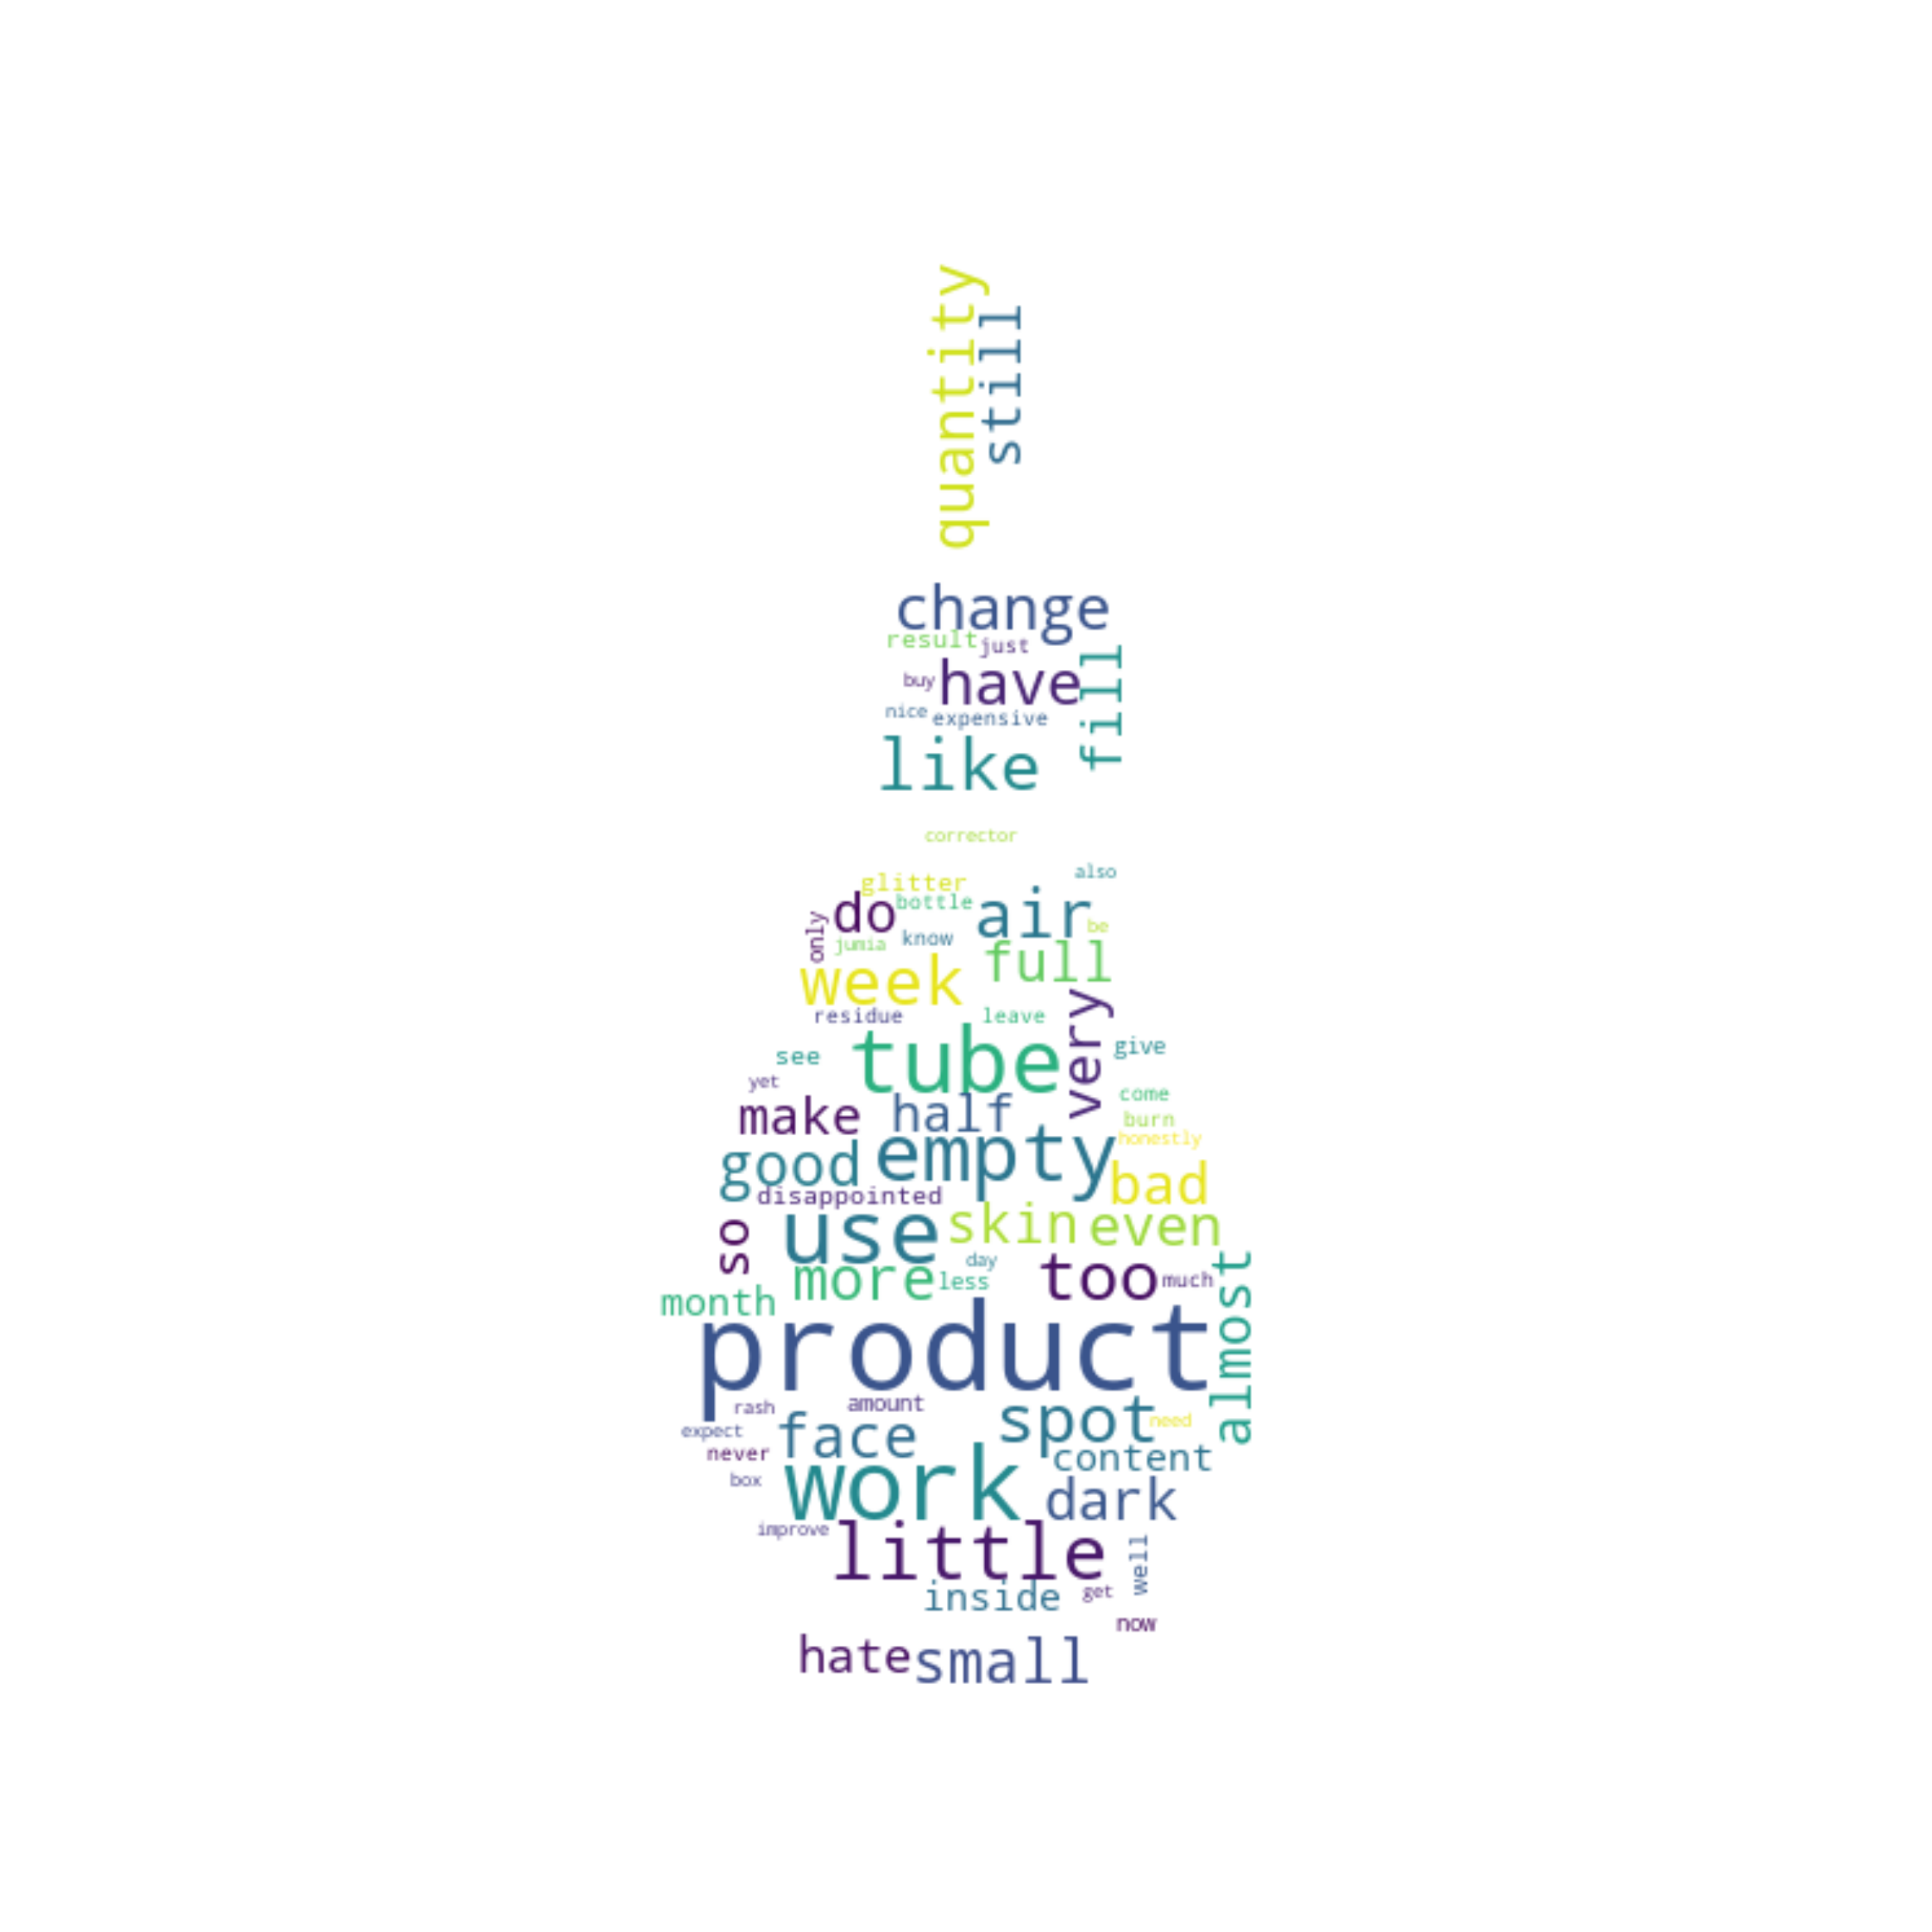

In [130]:
#from wordcloud import WordCloud

# define the mask 
#mask = np.array(Image.open("dropper-dispenser.jpg"))

# initialize the wordcloud
#wc = WordCloud(background_color="white", random_state=3, max_words=70, normalize_plurals=True, mask=mask).generate_from_frequencies(word_freq)

# plot
#plt.figure(figsize=(30,30))
#plt.imshow(wc, interpolation="bilinear")
#plt.axis("off")

#plt.savefig('spot-corrector-negative_reviews.png', dpi=300, bbox_inches='tight') # save image
#plt.show()